In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [3]:
# # Download caption annotation files
# annotation_folder = '/annotations/'
# if not os.path.exists(os.path.abspath('.') + annotation_folder):
#   annotation_zip = tf.keras.utils.get_file('captions.zip',
#                                           cache_subdir=os.path.abspath('.'),
#                                           origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
#                                           extract = True)
#   annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
#   os.remove(annotation_zip)

# # Download image files
# image_folder = '/train2014/'
# if not os.path.exists(os.path.abspath('.') + image_folder):
#   image_zip = tf.keras.utils.get_file('train2014.zip',
#                                       cache_subdir=os.path.abspath('.'),
#                                       origin = 'http://images.cocodataset.org/zips/train2014.zip',
#                                       extract = True)
#   PATH = os.path.dirname(image_zip) + image_folder
#   os.remove(image_zip)
# else:
#   PATH = os.path.abspath('.') + image_folder


#C:\Users\Dell\Desktop\Project Show and tell\image caption
annotation_file = os.path.abspath('.')+'/annotations/captions_train2014.json'
image_folder = r"C:\Users\Dell\Desktop\Project Show and tell\image caption\train2014"
PATH = os.path.abspath('.') + image_folder

In [4]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first few captions from the shuffled set
num_examples = 80000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [5]:
def load_image(image_path):
    img = tf.io.read_file(image_path)  #"%r"%
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [6]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [7]:
# # =========================== NEED NOT RUN THIS AGAIN ====================================
# # ========================= THIS IS TIME CONSUMING ==============================

# # Get unique images
# encode_train = sorted(set(img_name_vector))
# # Feel free to change batch_size according to your system configuration
# image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# image_dataset = image_dataset.map(
#   load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# for img, path in image_dataset:   
#   batch_features=image_features_extract_model(img)
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())

In [8]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

# Split into training and testing

In [10]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(64000, 64000, 16000, 16000)

# Create a tf.data dataset for training

In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [12]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Model

In [14]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [15]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [16]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [17]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [18]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

# Checkpoint

In [19]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [20]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [21]:
print(start_epoch)

76


# Training

In [22]:
# loss_plot = []

# @tf.function
# def train_step(img_tensor, target):
#   loss = 0

#   # initializing the hidden state for each batch
#   # because the captions are not related from image to image
#   hidden = decoder.reset_state(batch_size=target.shape[0])

#   dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

#   with tf.GradientTape() as tape:
#       features = encoder(img_tensor)

#       for i in range(1, target.shape[1]):
#           # passing the features through the decoder
#           predictions, hidden, _ = decoder(dec_input, features, hidden)

#           loss += loss_function(target[:, i], predictions)

#           # using teacher forcing
#           dec_input = tf.expand_dims(target[:, i], 1)

#   total_loss = (loss / int(target.shape[1]))

#   trainable_variables = encoder.trainable_variables + decoder.trainable_variables

#   gradients = tape.gradient(loss, trainable_variables)

#   optimizer.apply_gradients(zip(gradients, trainable_variables))

#   return loss, total_loss

In [23]:
# # =========================== NEED NOT RUN THIS ====================================

# EPOCHS = start_epoch + 8

# for epoch in range(start_epoch, EPOCHS):
#     start = time.time()
#     total_loss = 0

#     for (batch, (img_tensor, target)) in enumerate(dataset):
#         batch_loss, t_loss = train_step(img_tensor, target)
#         total_loss += t_loss

#         if batch % 100 == 0:
#             print ('Epoch {} Batch {} Loss {:.4f}'.format(
#               epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
#     # storing the epoch end loss value to plot later
#     loss_plot.append(total_loss / num_steps)
    
#     #write loss to file loss.txt                    #lint
#     file_loss = open('loss.txt','a')                #lint
#     s = ''                                          #lint
#     s += ',' + str(float(total_loss / num_steps))   #lint
#     file_loss.write(s)                              #lint
#     file_loss.close()                               #lint
    

#     if epoch % 1 == 0:           # % 5
#       ckpt_manager.save()

#     print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
#                                          total_loss/num_steps))
#     print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
#     #write time to file epoch_time.txt              #lint
#     file_time = open('epoch_time.txt','a')          #lint
#     s = ''                                          #lint
#     s += ',' + str(float(time.time() - start))      #lint
#     file_time.write(s)                              #lint
#     file_time.close()                               #lint
    

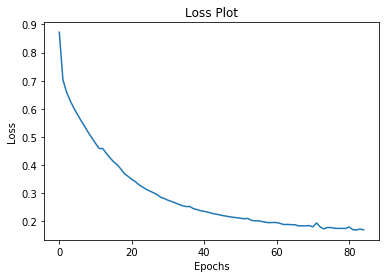

In [24]:
loss_plot = [0.871959,0.703491,0.659250,0.629192,0.603068,0.580390,0.558311,0.537062,0.516425,0.496505,
             0.477370,0.459196,0.458885,0.441358,0.4262796640396118,0.41154420375823975,0.40150725841522217,
             0.3861030340194702,0.3695577085018158,0.35997843742370605,0.34968870878219604,0.34127286076545715,
             0.33007970452308655,0.3221440613269806,0.3141552805900574,0.30794209241867065,0.3019329309463501,
             0.2952178716659546,0.2856859862804413,0.281353235244751,0.2755048871040344,0.2708593010902405,
             0.2661784887313843,0.26029300689697266,0.25619399547576904,0.2529524862766266,0.253090500831604,
             0.2457849681377411,0.2421848326921463,0.2380744367837906,0.23601651191711426,0.2332104593515396,
             0.22937417030334473,0.22640371322631836,0.22416797280311584,0.2211877405643463,0.21906018257141113,
             0.21655218303203583,0.21488766372203827,0.2133413553237915,0.21159055829048157,0.2094959169626236,
             0.2110067903995514,0.2040199488401413,0.20214547216892242,0.20234538614749908,0.1995750218629837,
             0.19712574779987335,0.19565728306770325,0.19649022817611694,0.19610872864723206,0.19283270835876465,
             0.18896132707595825,0.18953333795070648,0.18858720362186432,0.18840554356575012,0.1847374588251114,
             0.1844012439250946,0.18450677394866943,0.1854318082332611,0.1809948831796646,0.194843590259552,
             0.18082667887210846,0.1736583113670349,0.17872951924800873,0.17828674614429474,0.17586827278137207,
             0.1752791702747345,0.17565646767616272,0.17500679194927216,0.1805742383003235,0.17068184912204742,
             0.16999909281730652,0.1729496568441391,0.17019961774349213]

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Caption

In [25]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [26]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

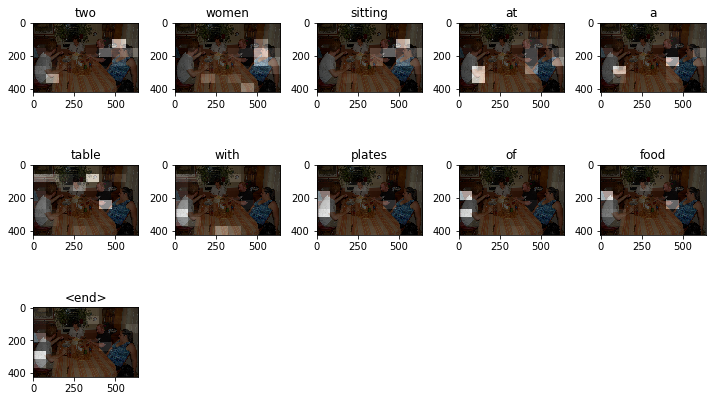

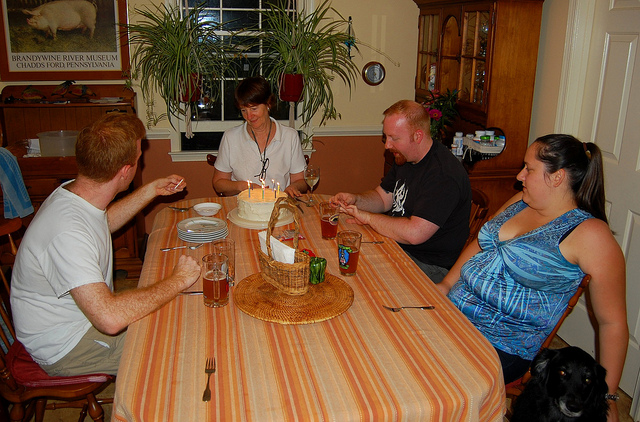

In [27]:
# image_path = r'C:\Users\Dell\Desktop\Project Show and tell\image caption\test\IMG_20191229_162359_Bokeh.jpg' #Enter image path with image name
image_path = str('C:/Users/Dell/Desktop/Project Show and tell/image caption/test/seq1/pic2.jpg')
result, attention_plot = evaluate(image_path)
# print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# multiple images in loop removing the end tag and unk tag

In [28]:
# # OG function
# def generate_story(image_path_list):
#     predicted_caption_list = []
#     i = 0
#     caption = ''
#     while(i<5):
#     #     image_path = r'C:\Users\Dell\Desktop\Project Show and tell\image caption\test\prof\pic' + '%0d.jpg' % (i)
#     #     image_path = r'C:\\Users\\Dell\\Desktop\\Project Show and tell\\image caption\\test\\seq1\\pic1.jpg' + '%0d.jpg' % (i)
#         result, attention_plot = evaluate(image_path_list[i])
#         caption = ' '.join(result) 
#         if(caption.find("<unk>") >= 0):
#             continue
#         s = caption.split(" <end>") #get the string and remove the <end>
#         predicted_caption_list.append(s[0])      #add it to the list
#         caption = caption + str(s[0])
# #         print ('Prediction Caption {}: {}'.format(i, s[0]))
#         i += 1
# #     print(predicted_caption_list)
#     story = []
#     for i in predicted_caption_list:
#         i = str(i[0].upper()) + '' + str(i[1:])
#         story.append(i)
#     story = str('. '.join(story))
#     return story

In [29]:
def generate_story(image_path_list):
    predicted_caption_list = []
    i = 0
    caption = ''
    while(i<5):
    #     image_path = r'C:\Users\Dell\Desktop\Project Show and tell\image caption\test\prof\pic' + '%0d.jpg' % (i)
    #     image_path = r'C:\\Users\\Dell\\Desktop\\Project Show and tell\\image caption\\test\\seq1\\pic1.jpg' + '%0d.jpg' % (i)
        result, attention_plot = evaluate(image_path_list[i])
        caption = ' '.join(result) 
        if(caption.find("<unk>") >= 0):
            continue
        s = caption.split(" <end>") #get the string and remove the <end>
        predicted_caption_list.append(s[0])      #add it to the list
        caption = caption + str(s[0])
#         print ('Prediction Caption {}: {}'.format(i, s[0]))
        i += 1
#     print(predicted_caption_list)
    story = []
    for i in predicted_caption_list:
        i = str(i[0].upper()) + '' + str(i[1:])
        story.append(i)
    story = str('. '.join(story))
    return story

# GUI

In [30]:
from tkinter import *
from PIL import ImageTk,Image
from tkinter import filedialog
import tkinter.messagebox

import time
import datetime

In [31]:
root = Tk()
root.title('Show and Tell: A Neural Visual Story-Teller')
root.configure(background='white')

l1=Label(root,text="Show and Tell: A Neural Visual Story-Teller",bd=1,relief="solid",font="Times 32",anchor=N).pack()
frame = LabelFrame(root,text="",padx=10,pady=50,background="white")
frame.pack(fill=BOTH,expand=TRUE)
generatedstory = str
path_list=['','','','','']
idir = "C:\\Users\\Dell\\Desktop\\Project Show and tell\\image caption\\test"
wtfdir = ""

def editidir(s):
    global idir
    s = s.split("/")
    s = s[:len(s)-1]
    idir = "\\\\".join(s)
    
def open1():
    global my_image1
    global path_list
    root.filename = filedialog.askopenfilename(initialdir = idir, title="select a file", filetypes=(("jpf files",".jpg"),("all files",".*")))
    path_list[0] = root.filename
    img1=Image.open(root.filename)
    img1 = img1.resize((250, 250))
    my_image1 = ImageTk.PhotoImage(img1)
    my_label_label = Label(frame,image=my_image1).grid(row=11,column=0)
    editidir(root.filename)
        

def open2():
    global my_image2
    global path_list
    root.filename = filedialog.askopenfilename(initialdir = idir, title="select a file", filetypes=(("jpf files",".jpg"),("all files",".*")))
    path_list[1] = root.filename
    img2=Image.open(root.filename)
    img2 = img2.resize((250, 250))
    my_image2 = ImageTk.PhotoImage(img2)
    my_label_label = Label(frame,image=my_image2).grid(row=11,column=1)
    editidir(root.filename)
    
def open3():
    global my_image3
    global path_list
    root.filename = filedialog.askopenfilename(initialdir = idir, title="select a file", filetypes=(("jpf files",".jpg"),("all files",".*")))
    path_list[2] = root.filename
    img3=Image.open(root.filename)
    img3 = img3.resize((250, 250))
    my_image3 = ImageTk.PhotoImage(img3)
    my_label_label = Label(frame,image=my_image3).grid(row=11,column=2)
    editidir(root.filename)

def open4():
    global my_image4
    global path_list
    root.filename = filedialog.askopenfilename(initialdir = idir, title="select a file", filetypes=(("jpf files",".jpg"),("all files",".*")))
    path_list[3] = root.filename
    img4=Image.open(root.filename)
    img4 = img4.resize((250, 250))
    my_image4 = ImageTk.PhotoImage(img4)
    my_label_label = Label(frame,image=my_image4).grid(row=11,column=3)
    editidir(root.filename)

def open5():
    global my_image5
    global path_list
    root.filename = filedialog.askopenfilename(initialdir = idir, title="select a file", filetypes=(("jpf files",".jpg"),("all files",".*")))
    path_list[4] = root.filename
    print(path_list)
    img5=Image.open(root.filename)
    img5 = img5.resize((250, 250))
    my_image5 = ImageTk.PhotoImage(img5)
    my_label_label = Label(frame,image=my_image5).grid(row=11,column=4)
    editidir(root.filename)


def generatestory():
    global generatedstory
    flag = True
    e = ['first','second','third','fourth','fifth']
    for i in range(0,5):
        if(path_list[i] == ''):
            flag = False
            errormessage = 'Enter '+ e[i] + ' image' 
            # Add error messagebox here
            tkinter.messagebox.showerror("Error", errormessage )
            break
    if(flag):
        start = datetime.datetime.today() #time.time().total_seconds()
#         print("before gs")
        generatedstory=generate_story(path_list)
#         print("after gs")
        print(generatedstory)
        done = datetime.datetime.today() #time.time().total_seconds()
        sec = str((done - start).seconds)#.split('.')
        microsec = str((done - start).microseconds)#.split('.')
        generatedstory += '\n\n Time taken: ' + str(sec) + '.' + str(microsec) + 's'
        tkinter.messagebox.showinfo("OUTPUT",generatedstory)
#     generatedstory = 'A black dog is looking out in the grass. A dogs play with very tall brown path. The dog going down a path in the driveway. A dog is jumping a dog being pulled out a fence. There is a dog sitting in a grassy part of a dirt field'
#     tkinter.messagebox.showinfo("OUTPUT",generatedstory)
    
    #delete this
    print(generatedstory)
    writetofile()

#delete this function
def writetofile(file_folder = 'test/pred.txt'):
    f = open(file_folder,'a') #temp for file
    f.write(idir.split("\\")[::-1][0] + "\n")
    f.write(generatedstory)
    f.write("\n\n")
    f.close()
        
for i in range(0,5):
    l=Label(frame,text=" ",background="white").grid(row=i,column=0)
    
my_btn1 = Button(frame, text="Open File 1", command=open1).grid(row=100,column=0)
my_btn2 = Button(frame, text="Open File 2", command=open2).grid(row=100,column=1)
my_btn3 = Button(frame, text="Open File 3", command=open3).grid(row=100,column=2)
my_btn4 = Button(frame, text="Open File 4", command=open4).grid(row=100,column=3)
my_btn5 = Button(frame, text="Open File 5", command=open5).grid(row=100,column=4)

for i in range(101,102):
    l=Label(frame,text=" ",background="white").grid(row=i,column=0)

my_btngs = Button(frame, text="Generate Story",command=generatestory).grid(row=104,column=2)


root.mainloop()

['C:/Users/Dell/Desktop/Project Show and tell/image caption/test/dog/pic1.jpg', 'C:/Users/Dell/Desktop/Project Show and tell/image caption/test/dog/pic2.jpg', 'C:/Users/Dell/Desktop/Project Show and tell/image caption/test/dog/pic3.jpg', 'C:/Users/Dell/Desktop/Project Show and tell/image caption/test/dog/pic4.jpg', 'C:/Users/Dell/Desktop/Project Show and tell/image caption/test/dog/pic5.jpg']
A dog is eating an orange ball in the grass. A dog running in a yard. A small dog holding the ocean while standing on the ground. A dog is playing on a deck. A dog is lying next to a red wall
A dog is eating an orange ball in the grass. A dog running in a yard. A small dog holding the ocean while standing on the ground. A dog is playing on a deck. A dog is lying next to a red wall

 Time taken: 2.334690s
The dog is playing in the grass. A very cute dogs two way up against a fence. A small dog holding a dog. A black dog is doing a white dog walks by a fence. A dog sits on while sitting on the edge 

# Extra

In [33]:
t = [0.6,1.2,1.8,2.39,3.71,4.1,4.8]

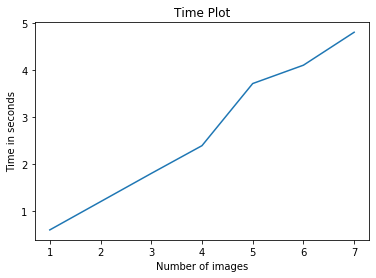

In [34]:
plt.plot([1,2,3,4,5,6,7],t)
plt.xlabel('Number of images')
plt.ylabel('Time in seconds')
plt.title('Time Plot')
plt.show()